In [379]:
import math
import graphviz
from graphviz import nohtml

class Value:
    def __init__(self, data: float, _children=(), _op:str=None, label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._children = _children
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data}, {self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(data=other)
        out = Value(data = self.data + other.data, _children = (self, other), _op = '+')
        def _backward ():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self+ (-other)

    def __neg__(self):
        return  self * -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(data=other)
        out = Value(data = self.data * other.data, _children = (self, other), _op = '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def tan(self):
        tan_val = (math.exp(2 * self.data) - 1)/(math.exp(2 * self.data) +1)
        out = Value(data =  tan_val, _children=( self, ), _op='tan')
        def _backward():
            self.grad += 1 - tan_val**2
        out._backward = _backward
        return out

    def exp(self):
        exp_val = math.exp(self.data)
        out = Value(exp_val, _op='exp', _children=(self,) )
        def _backward():
            self.grad += exp_val*out.grad
        out._backward = _backward
        return out

    def __pow__(self, power, modulo=None):
        power = power if isinstance(power, Value) else Value(data=power)
        out = Value(self.data**power.data, _op='**', _children=(self, power))
        def _backward():
            self.grad = (power.data* (self.data**(power.data-1)))*out.grad
            power.grad = (math.log(self.data)*(self.data**power.data))*out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(data=other)
        return self * (other**-1)

    def backward(self):
        self.grad = 1
        stack = [self]
        visited = set()
        while len(stack):
            cur = stack.pop()
            if cur not in visited:
                visited.add(cur)
                if cur._backward is not None:
                    cur._backward()
                if cur._children is not None:
                    stack+= cur._children


In [380]:
def draw_graph(parent: Value):
    f = graphviz.Digraph(node_attr={'shape': 'record'}, format='svg', graph_attr={'rankdir': 'LR'})
    stack = [parent];
    f.node(str(id(parent)),nohtml(f'<f0> {parent.label} |<f1> Data: {parent.data}|<f2>Grad: {parent.grad}'))
    while len(stack)!=0:
        cur = stack.pop()
        cur_uid = str(id(cur))
        if cur._op != None :
            f.node(name=cur_uid+cur._op, label=cur._op,shape='oval')
            f.edge(cur_uid+cur._op, cur_uid)
        if cur._children is not None:
            for children in cur._children:
                child_uid = str(id(children))
                f.node(child_uid ,nohtml(f'<f0> {children.label} |<f1> Data: {children.data}|<f2>Grad: {children.grad}'))
                if cur._op != None :
                    f.edge(child_uid, cur_uid+cur._op)
                stack.append(children)
    return f


In [381]:
# input
x1 = Value(data=2.0, label='x1')
x2 = Value(data=0.0, label='x2')
# weights
w1 = Value(data=-3.0, label='w1')
w2 = Value(data=1.0, label='w2')
#bias
b = Value(data=6.8814, label='b')

x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label='x1w1*x2w2 + b'
o = n.tan(); o.label='o'

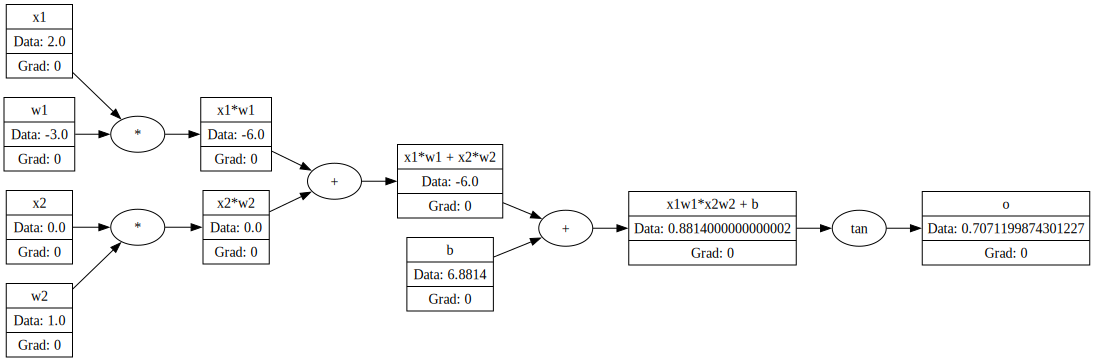

In [382]:
draw_graph(o)

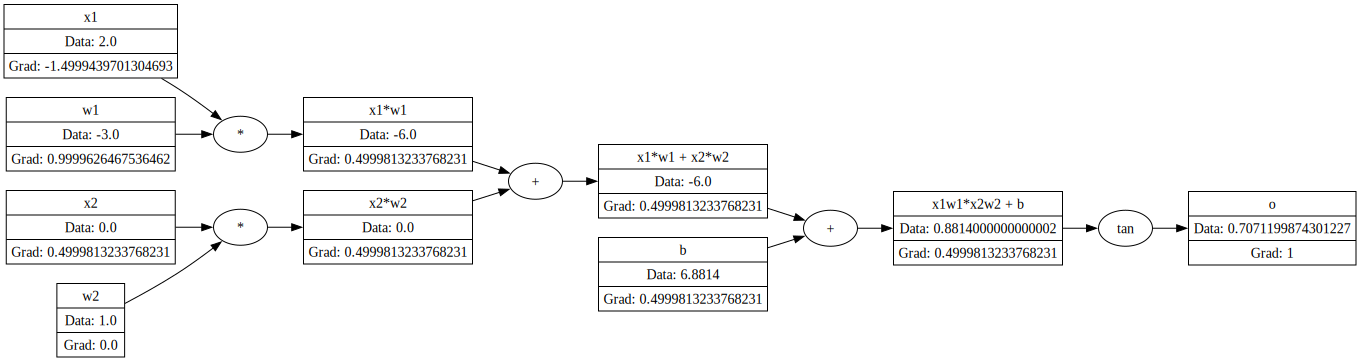

In [383]:
o.grad = 1
o.backward()
# o._backward()
# n._backward()
# x1w1_x2w2._backward()
# x2w2._backward()
# x1w1._backward()
draw_graph(o)

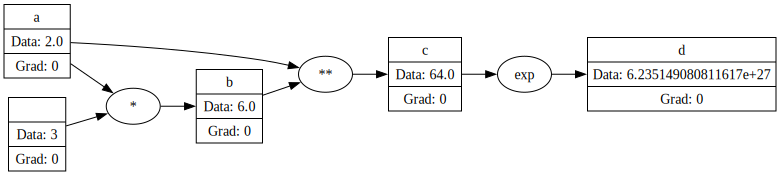

In [384]:
a = Value(2.0, label='a')
b = 3*a; b.label='b'
c = a**b; c.label='c'
d = c.exp(); d.label='d'
draw_graph(d)

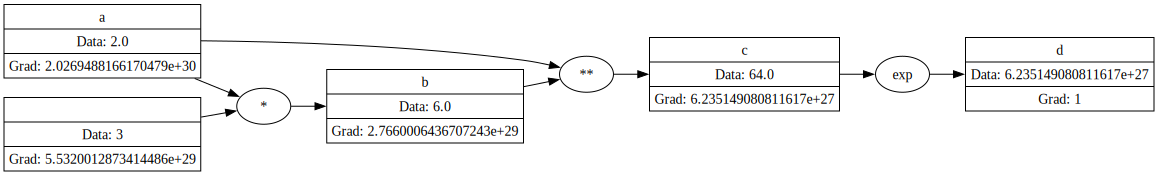

In [385]:
d.backward()
draw_graph(d)

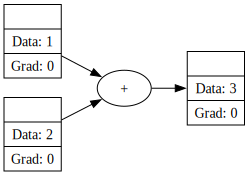

In [386]:
a = Value(1)
b = Value(2)
draw_graph(a+b)